# Load tfrecords, define model and train

In [2]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from keras import layers
from keras import models

# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint

# Check if the GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")



Tensorflow Version: 2.9.1
GPU not available :(


In [3]:
# load global settings in config-dictionary
with open('./MA_CONFIG.json', 'r') as fp:
  config = json.load(fp)

# define some extra values
config['batch_size'] = 16
config['shuffle_buffer_size'] = 300
config['n_epochs'] = 10
config['train_dataset_path'] = '../Dataset/train.tfrecord'
config['test_dataset_path'] = '../Dataset/test.tfrecord'


# print config
print(json.dumps(config, indent=4))

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)


{
    "batch_size": 16,
    "fps_noisy": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/noisySpeech",
    "fps_produced": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech",
    "fps_voicefixer": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/voicefixerOutput",
    "hop_length": 64,
    "input_shape": [
        441000,
        1
    ],
    "n_epochs": 10,
    "n_fft": 512,
    "n_mels": 16,
    "offset": 6,
    "sample_length": 20,
    "shuffle_buffer_size": 300,
    "sr": 44100,
    "test_dataset_path": "../Dataset/test.tfrecord",
    "train_dataset_path": "../Dataset/train.tfrecord",
    "win_length": 512
}


# load tfrecords

### func for decoding tfrecords

In [4]:
# autotune for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# decode tfrecords
def decode_tf_records(seralized_example):
    feature_description = {
        "voicefixer": tf.io.FixedLenFeature([], tf.string),
        "produced": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(seralized_example, feature_description)

    voicefixer, _ = tf.audio.decode_wav(example["voicefixer"], desired_channels=-1)
    produced, _ = tf.audio.decode_wav(example["produced"], desired_channels=-1)

    # voicefixer, produced = (
    #     tf.squeeze(voicefixer, 1),
    #     tf.squeeze(produced, 1),
    # )
    
    return voicefixer, produced

In [19]:
# load train tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/*.tfrecords')
train_dataset = tf.data.TFRecordDataset(tfrecords_paths)
train_dataset = train_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)

# # check tensors
# for element in train_dataset:
#     print(element[0])
#     print(element[1])
#     break

# # count elements in train_dataset
# print(f'Number of elements in train_dataset: {len([d for d in train_dataset])}')

# batching and shuffling
train_dataset = train_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


tf.Tensor(
[[-0.00042725]
 [-0.00042725]
 [-0.00057983]
 ...
 [ 0.00668335]
 [ 0.00820923]
 [ 0.00762939]], shape=(441000, 1), dtype=float32)
tf.Tensor(
[[ 1.8310547e-04]
 [ 1.1596680e-03]
 [ 1.1596680e-03]
 ...
 [ 1.2207031e-04]
 [ 3.0517578e-05]
 [-9.1552734e-05]], shape=(441000, 1), dtype=float32)


In [22]:
# load test tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test_tfrecords/*.tfrecords')
test_dataset = tf.data.TFRecordDataset(tfrecords_paths)
test_dataset = test_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)

# # check tensors
# for element in test_dataset:
#     print(element[0])
#     print(element[1])
#     break

# # count elements in test_dataset
# print(f'Number of elements in test_dataset: {len([d for d in test_dataset])}')

# batching and shuffling
test_dataset = test_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


In [23]:
# check if datasets are loaded correctly
for d in train_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break   

for d in test_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break

(16, 441000, 1)
(16, 441000, 1)
(16, 441000, 1)
(16, 441000, 1)


# look at data

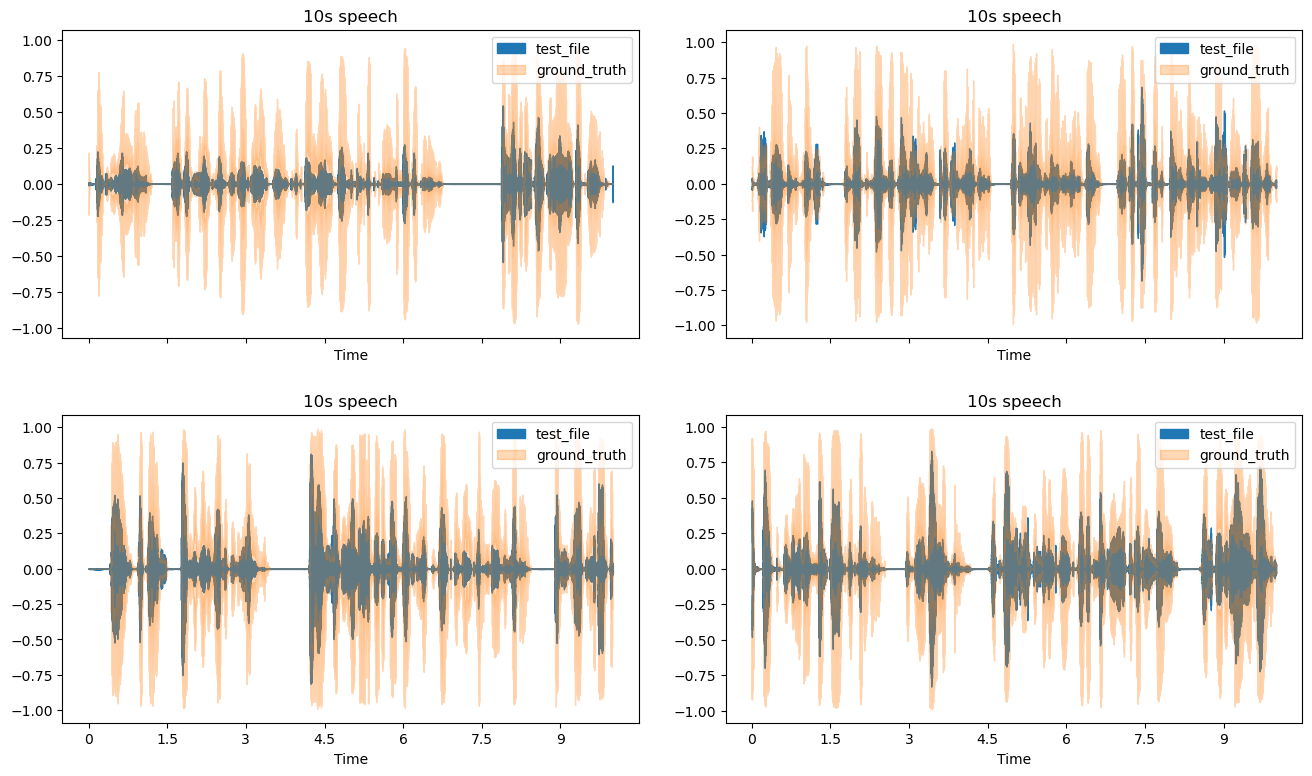

----------- 1. speechsnippet ---------------

Voicefixer file


corresponding produced file



----------- 2. speechsnippet ---------------

Voicefixer file


corresponding produced file



----------- 3. speechsnippet ---------------

Voicefixer file


corresponding produced file



----------- 4. speechsnippet ---------------

Voicefixer file


corresponding produced file


In [25]:
# look at some example data from train dataset
wavs = train_dataset.unbatch().as_numpy_iterator()
noisy = []
gt = []

# Setup Subplot
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# iterate over dataset
for i, sample in enumerate(wavs):
    
    # get the column and row by modulo and remainder
    j = i % ncols
    k = int(i / ncols)
    
    # extract noisy and produced speech file from tensors
    wave = sample[0]
    ground_truth = sample[1]
        
    # plot files
    librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
    librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
    ax[k][j].legend()
    ax[k][j].axis('on')
    ax[k][j].set_title('10s speech')  

    # save speech to arrays
    noisy.append(np.squeeze(wave))
    gt.append(np.squeeze(ground_truth))
    
    if i+1 == ncols*nrows:
        break
    
# adjust whitespace in between subplots        
plt.subplots_adjust(hspace=0.25, wspace=0.15)
plt.show()


# listen to the audio samples
for i in range(len(gt)):
    print(f'----------- {i+1}. speechsnippet ---------------')
    print('')
    print(f'Voicefixer file')
    pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
    print(f'corresponding produced file')
    pd.display(pd.Audio(gt[i].T, rate=config['sr']))
    print('')

## Model architecture

In [26]:
input_shape = (441000, 1)
output_channels = 1

filter_size = 8
kernel_size = 2

# build model with 12 layers
def build_model(input_shape):

    # define model
    model = keras.Sequential(name='PostNet_Conv1D')
    model.add(keras.Input(shape=input_shape))

    # add layer 
    model.add(keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, padding='same'))
    model.add(keras.layers.Activation('tanh'))

    # Add the remaining Conv1D layers
    for _ in range(11):
        model.add(keras.layers.Conv1D(filters=filter_size, kernel_size=kernel_size, padding='same'))
        model.add(keras.layers.Activation('tanh'))

    # Add the final Conv1D layer
    model.add(keras.layers.Conv1D(filters=output_channels, kernel_size=1, padding='same'))
    model.add(keras.layers.Activation('tanh'))

    return model

In [27]:
# get model
model = build_model(input_shape = input_shape)


# define metrics to monitor mse
metrics = [tf.keras.losses.MeanSquaredError()]

# Set up optimizer with high initial learning rate
opt = keras.optimizers.Adam(learning_rate=0.06)

# define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoint',
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
        
    # keras.callbacks.EarlyStopping(
    #     monitor='val_loss',
    #     patience=5,
    #     verbose=1),
]   

# compile model
model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanAbsolutePercentageError(),
              metrics=metrics)

model.summary()

Model: "PostNet_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 441000, 8)         24        
                                                                 
 activation_13 (Activation)  (None, 441000, 8)         0         
                                                                 
 conv1d_14 (Conv1D)          (None, 441000, 8)         136       
                                                                 
 activation_14 (Activation)  (None, 441000, 8)         0         
                                                                 
 conv1d_15 (Conv1D)          (None, 441000, 8)         136       
                                                                 
 activation_15 (Activation)  (None, 441000, 8)         0         
                                                                 
 conv1d_16 (Conv1D)          (None, 441000, 8)      

In [28]:
# fit model
history = model.fit(train_dataset,
                    epochs=config['n_epochs'],
                    validation_data=test_dataset,
                    callbacks=callbacks)

# save model
model.save('./model.h5')

# save history
with open('./history.json', 'w+') as fp:
    json.dump(history.history, fp, sort_keys=True, indent=4)



Epoch 1/10
     75/Unknown - 268s 4s/step - loss: 1129279.8750 - mean_squared_error: 0.0422

KeyboardInterrupt: 

In [ ]:
# plot mse
train_mse = history.history['mean_squared_error']
eval_mse = history.history['val_mean_squared_error']

fig2 = plt.figure()
plt.plot(range(config['n_epochs']), train_mse, label='train')
plt.plot(range(config['n_epochs']), eval_mse, label='test')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.title('Training with ' 
                           + str(config['n_epochs'])
                           + ' epochs \n batch-size: '
                           + str(config['batch_size']))
                     
plt.show()  

In [4]:
reconstructed_model = keras.models.load_model('./model.h5')


2023-06-06 16:37:24.381219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TypeError: __init__() got an unexpected keyword argument 'reduction'